# Clasificador binario para detectar sonrisas - TAREA 17
---
```
Universidad Nacional de San Antonio Abad del Cusco
Asignatura: Vision Computacional
Docente   : Ivan Cesar Medrano Valencia
Autores   : Etson Ronaldao Rojas Cahuana
Fecha     : 06/02/2022
Lugar     : Cusco, Perú
Proposito : Implementar un clasificador binario mediante una Red Neuronal Convolucional que nos diga si una persona en una foto está o no sonriendo.
```
---

# Introducción


En este cuaderno, se construira una red neuronal profunda que clasifica imagenes de sonrisas. Consiste en proporcionar una imagen de un rostro sonriendo para obtener la prediccion (con su etiqueta) y su respetivo porcentaje de clasificacion.

## Importar librerias necesarias

Para agilizar el procedimiento de entrenamiento y pruebas de hiperparametros se utilizara GPU local, si no se tiene GPU ignorar la siguiente celda.

In [ ]:
import os
#Cargar manualmente los dll necesarios para el uso de GPU, si no se tiene GPU no pasara nada.
os.add_dll_directory("C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.5/bin")

<AddedDllDirectory('C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.5/bin')>

Si no se tiene GPU se aplicará automaticamente la CPU.

In [ ]:
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import glob as glob
import imutils
import cv2
import numpy as np

Mostrar informacion de GPU.

In [ ]:
print("=====Mostrar informacion general de la TENSORFLOW Y KERAS=====")
print("Versions\nKeras:", keras.__version__,"\nTensorFlow: ",tf.__version__)
print("GPUs disponibles: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("\n=====Mostrar informacion general de la GPU=====")
#!nvidia-smi
!nvidia-smi -q

=====Mostrar informacion general de la TENSORFLOW Y KERAS=====
Versions
Keras: 2.7.0 
TensorFlow:  2.7.0
GPUs disponibles:  1

=====Mostrar informacion general de la GPU=====

==============NVSMI LOG==============

Timestamp                                 : Sun Feb  6 14:03:23 2022
Driver Version                            : 511.65
CUDA Version                              : 11.6

Attached GPUs                             : 1
GPU 00000000:01:00.0
    Product Name                          : NVIDIA GeForce RTX 3050 Ti Laptop GPU
    Product Brand                         : GeForce
    Product Architecture                  : Ampere
    Display Mode                          : Disabled
    Display Active                        : Disabled
    Persistence Mode                      : N/A
    MIG Mode
        Current                           : N/A
        Pending                           : N/A
    Accounting Mode                       : Disabled
    Accounting Mode Buffer Size           : 400

# 1. Cargar datos

Se recorre el directorio de imagenes de personas sonriendo obteniendo las etiquetas para cada conjunto de datos 0 para negativos (no sonrie) y 1 para positivos (sonrie).

*   SMILEs/
*       |--negatives/negatives7/ (9474 images)
*       |--positives/positives7/ (3690 images)


In [ ]:
#Lectura de imagenes del conjunto de datos, se leen en blanco y negro
def cargar_imagenes(direccion, data, label, name_label):
    for img in glob.glob(direccion):
        image = cv2.imread(img)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = imutils.resize(image, width = 48)
        image = img_to_array(image)
        data.append(image)
        label = name_label
        label = 1 if label == "positives" else 0
        labels.append(label)

In [ ]:
#Inicializar variables de datos
data = []
labels = []

#Direccion de imagenes
pos_path = 'SMILEs/positives/*/*.jpg'
neg_path = 'SMILEs/negatives/*/*.jpg'

cargar_imagenes(neg_path, data, labels, 'negatives')
cargar_imagenes(pos_path, data, labels, 'positives')

Se muestran algunas imagenes que se cargan.

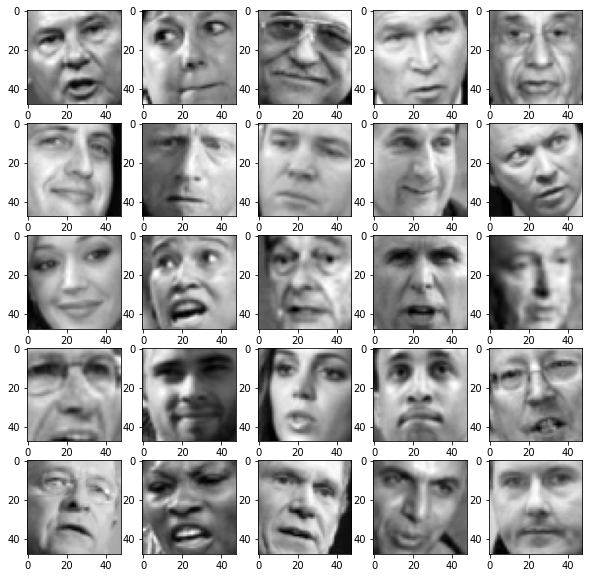

In [ ]:
#Especificando el tamaño total de la cuadrícula
plt.figure(figsize=(10,10)) 
for i in range(25):
    #El número de imágenes en la cuadrícula es 5*5 (25)
    plt.subplot(5,5,i+1)
    plt.imshow(data[i],cmap=plt.get_cmap('gray'))
plt.show()

# 2. Normalizar datos

In [ ]:
#Normalizar imagenes y las etiquetas
data = np.array(data, dtype = "float") / 255.0
labels = np.array(labels)

## 2.1 Separar datos

Data contiene las imagenes normalizadas y labels contiene las etiquetas a las que pertenecen.

*   data
*       |--trainX (80% de datos para entrenamiento)
*       |--testX (20% de datos para pruebas)
---

*   labels
*       |--trainY (80% de datos para entrenamiento)
*       |--testY (20% de datos para pruebas)

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size = 0.20, stratify = labels, random_state = 42)

# 3. Construccion del modelo

Se utilizara la libreria keras para la construccion de las capas secuenciales, capas pooling, capas flatten y capas densas.

In [ ]:
#Modelo 1
def modelo1_cnn():
    model =  keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(2, activation='softmax'))
    return model    

#Modelo2
def modelo2_cnn():
    model = keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
    model.add(tf.keras.layers.AveragePooling2D())
    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
    model.add(tf.keras.layers.AveragePooling2D())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=120, activation='relu'))
    model.add(tf.keras.layers.Dense(units=84, activation='relu'))
    model.add(tf.keras.layers.Dense(units=2, activation = 'softmax'))
    return model

# Se elige el modelo 2
model = modelo2_cnn()

Compilar modelo y describir.

In [ ]:
# Compile el modelo con optimizador y función de pérdida
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 46, 46, 6)         60        
                                                                 
 average_pooling2d_4 (Averag  (None, 23, 23, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_5 (Conv2D)           (None, 21, 21, 16)        880       
                                                                 
 average_pooling2d_5 (Averag  (None, 10, 10, 16)       0         
 ePooling2D)                                                     
                                                                 
 flatten_2 (Flatten)         (None, 1600)              0         
                                                                 
 dense_6 (Dense)             (None, 120)              

# 4. Entrenamiento del modelo

In [ ]:
# La función fit() carga iterativamente una gran cantidad de imágenes en lotes
history = model.fit(trainX,trainY, epochs=20, steps_per_epoch=40,
                    validation_data=(testX,testY), validation_steps=8)

Epoch 1/20
40/40 [==============================] - 1s 10ms/step - loss: 0.6027 - accuracy: 0.7086 - val_loss: 0.5640 - val_accuracy: 0.7197
Epoch 2/20
40/40 [==============================] - 0s 6ms/step - loss: 0.4593 - accuracy: 0.7729 - val_loss: 0.3608 - val_accuracy: 0.8397
Epoch 3/20
40/40 [==============================] - 0s 6ms/step - loss: 0.3386 - accuracy: 0.8498 - val_loss: 0.3405 - val_accuracy: 0.8507
Epoch 4/20
40/40 [==============================] - 0s 6ms/step - loss: 0.3067 - accuracy: 0.8686 - val_loss: 0.3064 - val_accuracy: 0.8747
Epoch 5/20
40/40 [==============================] - 0s 6ms/step - loss: 0.2848 - accuracy: 0.8801 - val_loss: 0.2981 - val_accuracy: 0.8777
Epoch 6/20
40/40 [==============================] - 0s 6ms/step - loss: 0.2761 - accuracy: 0.8863 - val_loss: 0.2893 - val_accuracy: 0.8853
Epoch 7/20
40/40 [==============================] - 0s 6ms/step - loss: 0.2650 - accuracy: 0.8897 - val_loss: 0.2843 - val_accuracy: 0.8899
Epoch 8/20
40/40 [=

## 4.1 Mostrar desemeño del modelo entrenado

In [ ]:
#Evaluar modelo entrenado
predictions = model.predict(testX, batch_size = 64)
test_loss, test_acc = model.evaluate(testX,  testY, verbose=0)
print('\nTest accuracy:', test_acc)


Test accuracy: 0.9077098369598389


## 4.2 Mostrar graficas de entrenamiento

Se observa que no hubo overfitting en el entrenamiento para 20 epocas.

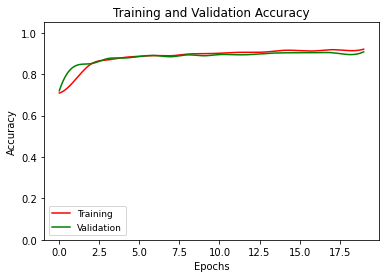

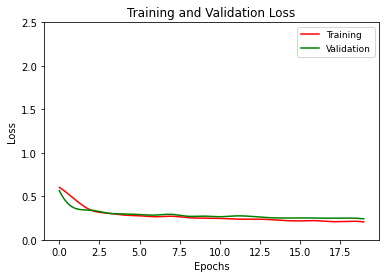

In [ ]:
from scipy.interpolate import make_interp_spline
xfer_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
xfer_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(xfer_acc))

x = np.array(epochs)
y = np.array(xfer_acc)
x_smooth = np.linspace(x.min(), x.max(), 500)
y_smooth = make_interp_spline(x, y)(x_smooth)
plt.plot(x_smooth, y_smooth, 'r-', label = 'Training')

x1 = np.array(epochs)
y1 = np.array(val_acc)
x1_smooth = np.linspace(x1.min(), x1.max(), 500)
y1_smooth = make_interp_spline(x1, y1)(x1_smooth)

plt.plot(x1_smooth, y1_smooth, 'g-', label = 'Validation')
plt.title('Training and Validation Accuracy')
plt.legend(loc = 'lower left', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,1.05)

plt.figure()
x = np.array(epochs)
y = np.array(xfer_loss)
x_smooth = np.linspace(x.min(), x.max(), 500)
y_smooth = make_interp_spline(x, y)(x_smooth)
plt.plot(x_smooth, y_smooth, 'r-', label = 'Training')

x1 = np.array(epochs)
y1 = np.array(val_loss)
x1_smooth = np.linspace(x1.min(), x1.max(), 500)
y1_smooth = make_interp_spline(x1, y1)(x1_smooth)

plt.plot(x1_smooth, y1_smooth, 'g-', label = 'Validation')
plt.title('Training and Validation Loss')
plt.legend(loc = 'upper right', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,2.5)
plt.show()

# 5. Predicciones

En esta seccion se crean 3 modulos que predicen los datos de test y con imagenes externas.

In [ ]:
#Solo tenemos dos clases 0 y 1, de los cuales les daremos un nombre para una mejor descripcion de la prediccion.
class_names = ['no sonrie', 'sonrie']
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  #plt.imshow(img, cmap=plt.cm.binary)
  plt.imshow(img,cmap=plt.get_cmap('gray'))
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label.any():
    color = 'blue'
  else:
    color = 'red'
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(2))
  plt.yticks([])
  thisplot = plt.bar(range(2), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

def predecir_imagen_externa(path_img):
    image = cv2.imread(path_img)
    plt.subplot(1,2,1)
    plt.grid(False)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Imagen original')
    plt.subplot(1,2,2)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = imutils.resize(image, width = 48)
    plt.imshow(image,cmap=plt.get_cmap('gray'))
    image = img_to_array(image)
    image = np.array([image], dtype = "float") / 255.0
    predice = model.predict(image, batch_size = 64)
    predicted_label = np.argmax(predice)
    plt.title("Prediccion:\n{} {:2.0f}% ".format(class_names[predicted_label],100*np.max(predice),color=[255,0,0]))
    plt.show()

## 5.1 Predicciones con datos de test

Predecir la imagen numero 100 del conjunto de datos de test.

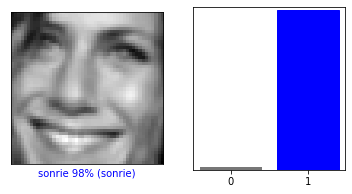

In [ ]:
#Imagen numero i del conjunto de datos de test
i = 100
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], testY, testX)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  testY)
plt.show()

Mostrar mas predicciones del conjunto de datos de test.

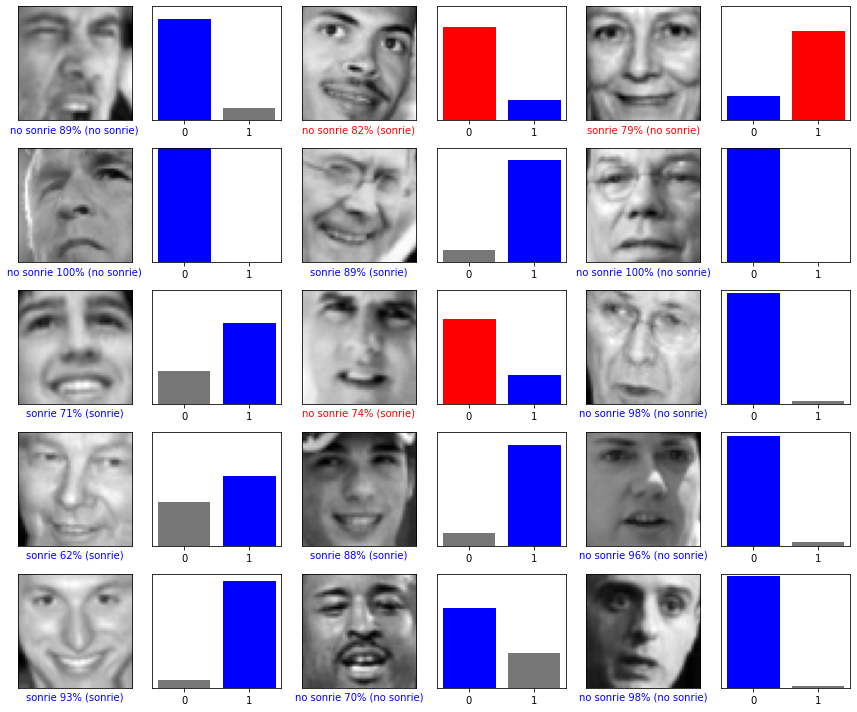

In [ ]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], testY, testX)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], testY)
plt.tight_layout()
plt.show()

## 5.2 Predicciones con datos externos

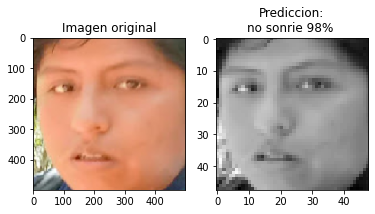

In [ ]:
predecir_imagen_externa('tacusi.jpg')

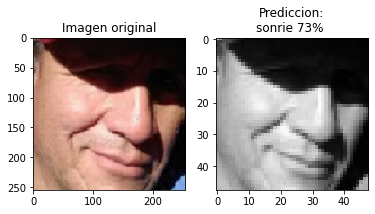

In [ ]:
predecir_imagen_externa('profesor.jpg')

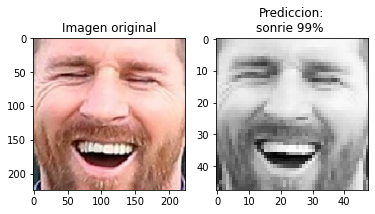

In [ ]:
predecir_imagen_externa('messi.jpg')

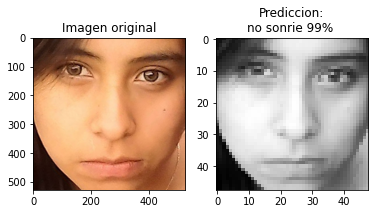

In [ ]:
predecir_imagen_externa('mel.jpg')

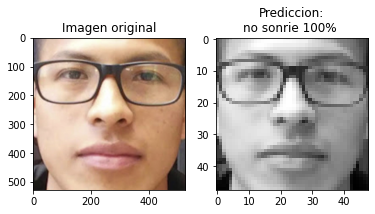

In [ ]:
predecir_imagen_externa('rosmel.jpg')

Guardar el modelo generado.

In [ ]:
model.save('modelo_generado.h5')